# Loading in DroneRF data and combining segments into NumPy format

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from src.data.load_data import load_all_segments

In the context of the DroneRF dataset, a "segment" refers to a single recording of RF data. Each segment represents a continuous period of data collection for capturing a specific drone activity or background RF noise. The dataset splits each segment into two parts: "High" and "Low". "High" refers to the higher frequency components of the signal while "Low" refers to the lower frequency components of the signal. Let's start off by using 5 pairs of segments

In [10]:
base_path = './data/raw/known_signal_subset'
data = load_all_segments(base_path, num_segments = 10)

print(f"Loaded data shape: {data.shape}")

100%|███████████████████████████████████████████| 10/10 [02:00<00:00, 12.00s/it]


Loaded data shape: (5000, 10000, 2)


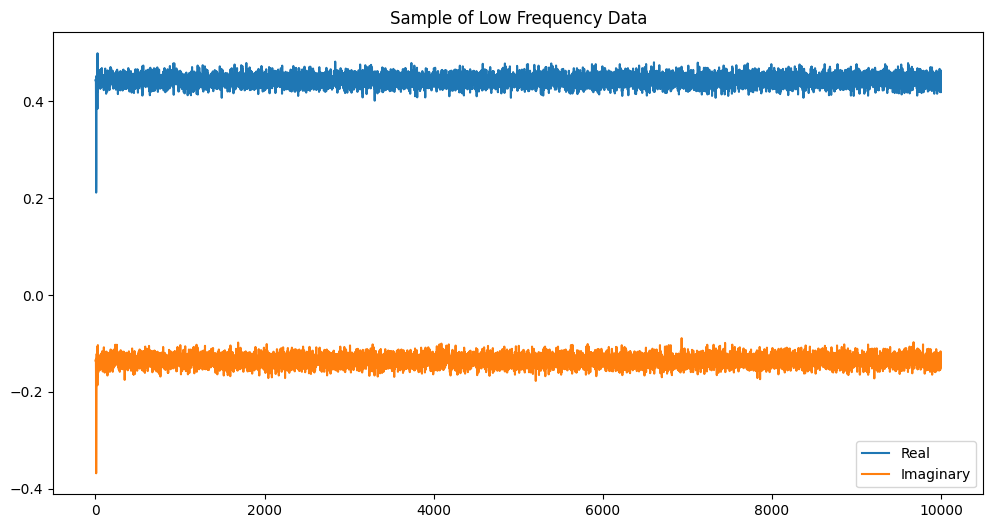

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(data[0, :, 0].real)
plt.plot(data[0, :, 0].imag)
plt.title("Sample of Low Frequency Data")
plt.legend(["Real", "Imaginary"])
plt.show()

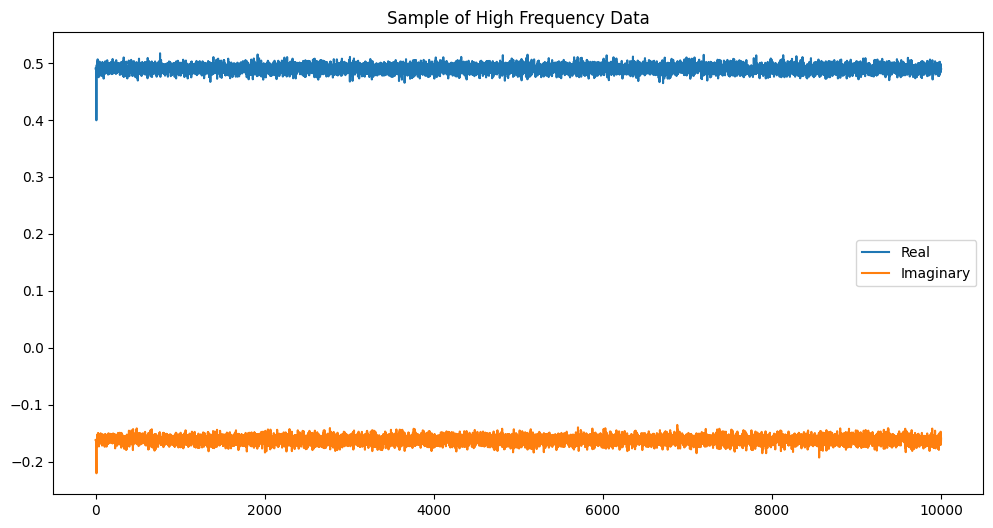

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data[0, :, 1].real)
plt.plot(data[0, :, 1].imag)
plt.title("Sample of High Frequency Data")
plt.legend(["Real", "Imaginary"])
plt.show()
